## Predictive Customer Lifetime Value

# Business Goal: Identify Highest Value Customers using Machine Learning

Customer lifetime value (CLV) is one the most commonly used metric to know your customer’s worth. What can you do with it? <br> Once you identify customers as, let’s say, high / medium / low value,
target different buckets accordingly
understand customer habits that put them in high value bucket
acquire new customers who are more likely to mimic high value customers

### Prediction
if customer is unseen for a given period of time they are likely to not come back as they are exposed to other options; especially in an essential service e-commerce setting.

In [1]:
import lifetimes
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from lifetimes.datasets import load_dataset
import lifetimes 
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes import GammaGammaFitter
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
import psycopg2
import sqlalchemy as sa
#from sqlalchemy import create_engine
import boto3
import seaborn as sns

from pybats.analysis import analysis
from pybats.point_forecast import median, mean
from pybats.plot import plot_data_forecast, ax_style
from pybats.loss_functions import MAD, MSE, MAPE

import pandas as pd
import numpy as np
import pybats as pb
import sqlalchemy as sa
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
import psycopg2
import boto3
from sshtunnel import SSHTunnelForwarder
import matplotlib.pyplot as plt
from pybats.analysis import *
from pandas.tseries.holiday import USFederalHolidayCalendar
holidays = USFederalHolidayCalendar.rules
# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
fig = plt.figure(figsize=(20,10))


from snowflake.sqlalchemy import URL
import snowflake.connector as sf

<Figure size 1440x720 with 0 Axes>

### Model Based on Negative-Binomial Distribution; using NB Regression 
The Beta Geometric/Negative Binomial Distribution model was introduced in 2004 by P. Fader’s Paper as an improvement of the Pareto/NBD model (the first BTYD) developed by Schmittlein et al. in 1987.

**Recency** (derived from tₓ): the age of the customer at the moment of his last purchase, which is equal to the duration between a customer’s first purchase and their last purchase.  It is the point (relative to their own period of observation) at which the customer made their most recent repeat purchase. This can also be thought of the length of time between a customer’s first and last purchase for the period, measured in increments defined by freq

**Frequency** (x): the number of periods in which the customer has made a repeat purchase.  It is the number of repeat purchases the customer made during the observation period.

**Age of the customer** (T): the age of the customer at the end of the period under study, which is equal to the duration between a customer’s first purchase and the last day in the dataset.  This can also be thought of the length of time between a customer’s first purchase and the end of the period, measured in increments defined by freq

# Database Connection

In [2]:
#Vuori
url = URL(
    host='...',
    user='...',
    password='...',
    account='...', 
    database='...',
    warehouse='...'
    )
#Create a cursor object.
engine = create_engine(url)
connection = engine.connect()

### Run this in Redshift / Snowflake:
GRANT ALL ON ALL TABLES IN SCHEMA [drp_staging] TO amour_vert_looker

### SQL script
for the predictive LTV model, data needs to be pulled for each customer to include each order date, the number products ordered, and the average amount of the order

In [3]:
sql_ltv = ("""SELECT customer_id, email
                 , date_trunc('month', CAST(order_date as DATE)) as date
                 , count(product_amount) as orders
                 , avg(product_amount) as amount
        FROM uos.orders
        WHERE date >= '2016-01-01'
        AND product_amount >= 0
        GROUP BY customer_id, email, date
""")

### Forecasting SQL Script

In [283]:
# Weekly Data Works Best
sql_forecast = """with sales_table as
         (
             select date_trunc('week', CAST(date_day as DATE)) as week_date, sum(total_gross_margin) as total_gross_margin, avg(prod_discount) as avg_disc, avg(avg_price) as a_price, (avg_disc/a_price) as pdisc, sum(total_units) as total_units, sum(num_orders) as total_orders
             from (
                 select
                     order_id
                   , order_date as date_day
                   , sum(gross_margin) AS total_gross_margin
                   , avg(olr.product_price) as avg_price
                   , avg(olr.product_discount_amount) as prod_discount
                   , sum(num_units) AS total_units
                   , count(distinct order_id) as num_orders
                 from drp.order_line_revenue olr
                 WHERE valid_order_flag = 1
                 group by date_day, order_id
             ) as first
             GROUP BY week_date
             ORDER BY week_date
         )
         select * from sales_table
         order by week_date"""

In [129]:
sql_forecast_product = """with sales_table as
  (
     select date_trunc('week', CAST(date_day as DATE)) as week_date, product_type, avg(prod_discount) as avg_disc, avg(avg_price) as a_price, (avg_disc/a_price) as pdisc, sum(total_gross_margin) as total_gross_margin, sum(total_units) as total_units, sum(num_orders) as total_orders
     from (
         select
             order_id
           , order_date as date_day
           , olr.sku
           , sa.product_type as product_type
           , avg(olr.product_price) as avg_price
           , avg(olr.product_discount_amount) as prod_discount
           , sum(gross_margin) AS total_gross_margin
           , sum(num_units) AS total_units
           , count(distinct order_id) as num_orders
         from drp.order_line_revenue olr
         left join drp.sku_attributes sa on sa.sku = olr.sku
         WHERE valid_order_flag = 1 
         group by date_day, order_id, olr.sku, sa.product_type
     ) as first
     GROUP BY week_date, product_type
     ORDER BY product_type, week_date
  )
  select * from sales_table
  order by product_type, week_date"""

## Functions

In [5]:
def get_data_rs(s, rs_dict):
    engine = sa.create_engine('redshift+psycopg2://'+rs_dict['user']+':'+rs_dict['password']+
                          '@'+rs_dict['host']+':'+rs_dict['port']+'/'+rs_dict['dbname'], connect_args={'sslmode': 'prefer'})
    con = engine.raw_connection()
    df = pd.read_sql(sql, con)
    df.dropna(axis=0,inplace=True)
    df1 = df.sample(frac=s, replace=False)
    df1['date'] = pd.to_datetime(df.date)
    df1['email'] = df1['email'].str.lower()
    datemax = df1.date.max()
    return df1, datemax

In [6]:
def get_data_sf(s, sql):
    engine = create_engine(url)
    con = engine.raw_connection()
    df = pd.read_sql(sql, con)
    df.dropna(axis=0,inplace=True)
    df1 = df.sample(frac=s, replace=False)
    df1.columns = map(str.lower, df1.columns)
    df1['date'] = pd.to_datetime(df1.date)
    df1['email'] = df1['email'].str.lower()
    datemax = df1.date.max()
    return df1, datemax

In [7]:
def rfm_model(data, end_date, f, p):
    rfm1 = lifetimes.utils.summary_data_from_transaction_data(
    data,
    'customer_id',
    'date',
    monetary_value_col='amount',
    observation_period_end=end_date,
    freq=f)
    rfm1 = rfm1[rfm1.monetary_value < 600]
    bgf = BetaGeoFitter(penalizer_coef=p)
    bgf.fit(rfm1['frequency'], rfm1['recency'], rfm1['T'])
    return rfm1, bgf

In [8]:
def rfm_predict(rfm_table, bgf_model, t):
    rfm_table['predicted_num_trxn'] = bgf_model.conditional_expected_number_of_purchases_up_to_time(t, rfm_table['frequency'], rfm_table['recency'], rfm_table['T'])
    rfm_table['probability_alive'] = bgf_model.conditional_probability_alive(rfm_table['frequency'], rfm_table['recency'], rfm_table['T'])
    rfm_table.sort_values(by='predicted_num_trxn')
    return rfm_table

In [9]:
def gg_model(rfmmod, bgf, p, f):
    # Build the Model
    ret_cust = rfmmod[(rfmmod['frequency'] > 0) & (rfmmod['monetary_value'] > 0)]
    ggf = GammaGammaFitter(penalizer_coef = p)
    ggf.fit(ret_cust['frequency'],ret_cust['monetary_value'])
    pred_clt = ggf.customer_lifetime_value(
        bgf, 
        ret_cust['frequency'],
        ret_cust['recency'],
        ret_cust['T'],
        ret_cust['monetary_value'],
        time=12, # months
        freq=f,
        discount_rate=0.01)
    ret_cust['predicted_cltv'] = pred_clt
    ret_cust['exp_profit'] = ggf.conditional_expected_average_profit(ret_cust['frequency'],ret_cust['monetary_value'])
    ret_cust = ret_cust.sort_values('predicted_cltv', ascending=False).round(3)
    return ret_cust

In [10]:
def merge(df_rfm, df_holdout, thresh):
    df_new = pd.merge(df_rfm, df_holdout, on='customer_id')
    df_new.sort_values('predicted_cltv', ascending=False)
    df_new_red = df_new[(df_new.predicted_cltv < thresh) & (df_new.amount < thresh)]
    return df_new, df_new_red

In [11]:
def send_data(results, table_name):
    engine = create_engine(url)
    con = engine.raw_connection()
    results.to_sql(table_name, con=engine, schema='drp_staging', method='multi', chunksize=16000, index=False, if_exists='replace')
    print(table_name+' updated!')

In [12]:
def get_holdout(df, days):
    hold_end = df.date.max()
    hold_begin = hold_end-pd.to_timedelta(days, unit='d')
    df_hold1 = df[(df.date > hold_begin) & (df.date < hold_end)]
    df_hold2 = df_hold1.groupby('customer_id').agg({'orders':'count', 'amount':'sum'}).reset_index()
    df_hold2.columns = ['customer_id', 'trxn', 'amount']
    return df_hold2, hold_begin, hold_end

In [13]:
def km_rfm(rfm_table, threshold):
    rfm_km = rfm_table[['recency', 'frequency', 'monetary_value']]
    rfm_km_r = rfm_km[rfm_km.monetary_value < threshold]
    #standardize all the data:
    standard_scaler = StandardScaler()
    RFM_norm1 = standard_scaler.fit_transform(rfm_km_r)
    RFM_norm1 = pd.DataFrame(RFM_norm1)
    RFM_norm1.columns = ['Recency','Frequency','Amount']
    # Run the K-Means Algorithm
    model_clus3 = KMeans(n_clusters = 3, max_iter=150)
    model_clus3.fit(RFM_norm1)
    rfm_km_r['clusterid'] = model_clus3.labels_
    rfm_cluster = rfm_km_r.reset_index()
    rfm_cluster_group = rfm_cluster.groupby('clusterid')[['recency', 'frequency','monetary_value']].mean().sort_values('recency', ascending=True).reset_index()
    return rfm_cluster, rfm_cluster_group

In [14]:
def ltv_valid(orig_df, bgf_model, cal_hold_end, end_obs_date, frq, t):
    cal_hold = calibration_and_holdout_data(orig_df, 
                                   'customer_id', 
                                   'date',
                                   calibration_period_end=cal_hold_end, #3 years calibration
                                   observation_period_end=obs_end, #2 year holdout
                                   freq = frq)
    cal_hold['predicted_purchases'] = bgf_model.conditional_expected_number_of_purchases_up_to_time(t, cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])
    cal_pred = cal_hold.groupby('frequency_cal')['predicted_purchases'].mean().round(2)
    y1 = pd.DataFrame(cal_pred)
    y1 = y1[y1.index < 7]
    cal_hold_pred = cal_hold.groupby('frequency_cal')['frequency_holdout'].mean()
    y2 = pd.DataFrame(cal_hold_pred)
    y2 = y2[y2.index <7]
    df_y = y1
    df_y['y2'] = y2
    df_y.columns=['predicted', 'holdout']
    df_y['diff'] = df_y['predicted'] - df_y['holdout']
    df_y['percent_error'] = df_y['diff']/df_y['holdout']
    df_y = df_y.reset_index()
    print('Mean Accuracy', df_y.percent_error.mean())
    sns.lineplot(df_y.index, df_y.predicted)
    sns.lineplot(df_y.index, df_y.holdout)
    return df_y

In [ ]:
from random import shuffle
def shuffle_word(word):
    word = list(word)
    shuffle(word)
    return ''.join(word)

In [ ]:
profit_margin = 0.05
rfm_gamma['CLV'] = rfm_gamma['predicted_cltv']*profit_margin              

# Run Code

## Step 1: Get and Process the Data

In [15]:
# Get the data. Set the first parameter to get a random sample of the dataset.
# (use this for extremely large datasets.)
df, max_date = get_data_sf(1, sql_ltv)

# set values 
#time horizon in the unit frequency (i.e. Days, Months, Weeks, etc.)
t = 12

# Frequecy 
frq = 'M'

# Holdout dataset
df_hold, h_beg, h_end = get_holdout(df, 365)

In [16]:
#check the function output
print(max_date)
print(h_beg)
print(h_end)
print('dataframe: ', df.shape)
print('holdout data: ', df_hold.shape)
df.head()

2020-12-01 00:00:00
2019-12-02 00:00:00
2020-12-01 00:00:00
dataframe:  (950780, 5)
holdout data:  (433886, 3)


,customer_id,email,date,orders,amount
314052,25daeb968cde67f5bde46a00754de4d7,james.bicknell666@hotmail.com,2019-11-01,1,89.0
435051,ea737bc9700a171147768ecf82bc74a2,shirleylangley@aol.com,2020-10-01,1,84.0
232517,33bf03962e04bd2e70ebf9b950670dc6,jdapple7373@gmail.com,2019-09-01,1,84.0
252233,272f670fa4b1e384022f09b2fcc59284,rslord22@icloud.com,2019-05-01,1,68.0
520519,8ab9d3b0018314bb270f083b7364a3bc,kswellsmd@gmail.com,2020-09-01,1,142.0


### Step 2: Run the Neg. Binomial Model 

In [17]:
# get stop date for last year
max_last = max_date-pd.to_timedelta(365, unit='d')
print(max_last)
# run NB the model: 

rfm_mod, bgf_mod = rfm_model(df, max_last, frq, 0.01)
bgf_mod.summary

2019-12-02 00:00:00


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.331856,0.003252,0.325483,0.338230
alpha,6.662923,0.093040,6.480565,6.845280
a,0.127111,0.004596,0.118103,0.136119
b,0.337729,0.010225,0.317688,0.357770


In [18]:
rfm_mod_all, bgf_mod_all = rfm_model(df, max_date, frq, 0.01)
bgf_mod_all.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.458479,0.002289,0.453992,0.462967
alpha,7.401226,0.049497,7.304212,7.498239
a,0.038833,0.001401,0.036086,0.041579
b,0.219589,0.006468,0.206912,0.232266


### Step 3: Run the Clustering Algorithm on the RFM Table

In [137]:
rfm_cluster, rfm_cluster_group = km_rfm(rfm_mod_all, 500)
rfm_cluster_group

,clusterid,recency,frequency,monetary_value
0,0,0.023489,0.013236,0.767625
1,1,5.799614,1.440840,153.838949
2,2,25.866904,3.792726,158.561384


In [138]:
rfm_cluster_group['new_cl_id']=rfm_cluster_group.index.values
rfm_cluster_group

,clusterid,recency,frequency,monetary_value,new_cl_id
0,0,0.023489,0.013236,0.767625,0
1,1,5.799614,1.440840,153.838949,1
2,2,25.866904,3.792726,158.561384,2


### Step 4: Run the CLTV Prediction

In [118]:
# set the time period for predicting transactions / probability alive
t = 12

rfm_pred = rfm_predict(rfm_mod_all, bgf_mod_all, t)
print('Predicted rfm shpae:', rfm_pred.shape)

# This is the final CLTV Predictions that need to be pushed back to the database.
# this has the 0 frequency transactions removed...
rc = gg_model(rfm_pred, bgf_mod_all, 0.01, frq)
rc

Predicted rfm shpae: (622270, 6)


,frequency,recency,T,monetary_value,predicted_num_trxn,probability_alive,predicted_cltv,exp_profit
customer_id,,,,,,,,
810f12ddfc3641f9a701a178e365cd66,16.0,16.033,16.033,505.986,8.305,0.997,3975.237,510.254
9c033428fb62699606ecd1280f10ca58,33.0,54.013,54.013,580.327,6.498,0.999,3551.292,582.673
ccc87c3a6763de7744ef040d6772e1d7,10.0,9.988,9.988,516.417,7.071,0.996,3471.946,523.410
21a233c150a998d3eeee8e39ff525c1c,9.0,9.988,9.988,570.209,6.390,0.995,3469.544,578.754
b092cabb8dddd6a1e4ac296c9dd95e5f,16.0,16.033,16.033,417.939,8.305,0.997,3283.843,421.508
...,...,...,...,...,...,...,...,...
0fc12c82f1fdd77336b64a869a8fae3e,1.0,0.953,57.989,18.500,0.057,0.215,1.379,25.754
bbc41857f54730b2f086ee3bff0dad18,1.0,0.953,57.989,18.500,0.057,0.215,1.379,25.754
25f4b57a8439bb43d4eb038fa9934326,1.0,1.019,59.007,19.000,0.056,0.214,1.376,26.326


In [619]:
import re

In [119]:
print(f"Expected Average Sales: {rc['exp_profit'].mean()}")
print(f"Actual Average Sales: {rc['monetary_value'].mean()}")

Expected Average Sales: 173.66919203585178
Actual Average Sales: 154.12190035875616


In [ ]:
df2 = df.drop_duplicates(subset=['email']) 
df2.shape#df.drop_duplicates(subset=['brand'])
df_final = rc.merge(df2[['customer_id','email']], on='customer_id')
df_final = df_final.merge(rfm_cluster[['customer_id','clusterid']], on='customer_id')
df_final['clusterid'] = df_final['clusterid'].map({0:'LVC', 1:'Avg. Cust.', 2:'HVC'})
df_final['wholesaler'] = np.where(df_final['predicted_cltv'] < 1000, 0, 1)
df_final['churn_group'] = np.where(df_final['probability_alive'] < .5, 0, 1)
df_final['pred_trxn'] = df_final.predicted_num_trxn.round(0)
df_final['email_anonymous'] = [shuffle_word(word) for word in df_final['email']]

### Predicted CLV by Trx Summary Table

In [123]:
pt1 = df_final[df_final.wholesaler != 1]
pt = pd.DataFrame(pt1.groupby('pred_trxn')['predicted_cltv'].mean()).reset_index()
pt['percent_total'] = pt1.groupby('pred_trxn')['predicted_cltv'].count()/len(pt1)
pt

,pred_trxn,predicted_cltv,percent_total
0,0.0,50.770276,0.165185
1,1.0,154.384553,0.573332
2,2.0,303.371316,0.190012
3,3.0,448.238999,0.055537
4,4.0,573.005850,0.012444
5,5.0,670.624164,0.002884
6,6.0,719.668659,0.000550
7,7.0,826.647333,0.000054


### Validation Table

Mean Accuracy -0.017721769699932867


,frequency_cal,predicted,holdout,diff,percent_error
0,0.0,0.27,0.377160,-0.107160,-0.284123
1,1.0,0.55,0.744999,-0.194999,-0.261744
2,2.0,1.10,1.075969,0.024031,0.022334
3,3.0,1.48,1.355124,0.124876,0.092151
4,4.0,1.77,1.632037,0.137963,0.084534
5,5.0,2.07,1.829699,0.240301,0.131334
6,6.0,2.33,2.134752,0.195248,0.091462


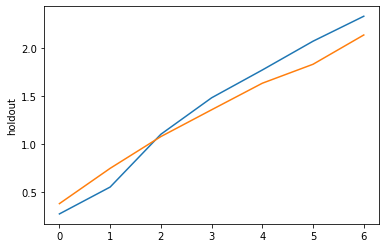

In [124]:
cal_hold_end = max_date-pd.to_timedelta(365, unit='d')
obs_end = df.date.max()
frq = 12

pred_trx_sum = ltv_valid(df, bgf_mod, cal_hold_end, obs_end, 'M', 12)
pred_trx_sum

### Step 4: Send Back to Database

In [638]:
# Send the Predicted LTV Matrix to the Database
send_data(df_final, 'predict_ltv')

# Send Data to Summary CLTV Table
send_data(pt, 'summary_cltv')

# Send Validation to the Database
send_data(pred_trx_sum, 'predicted_trx_summary')

predict_ltv updated!
summary_cltv updated!
predicted_trx_summary updated!


# Model Plots

In [ ]:
plot_period_transactions(bgf_mod)

In [ ]:
cal_hold = calibration_and_holdout_data(df, 
                                   'customer_id', 
                                   'date',
                                   calibration_period_end='2018-11-30', #3 years calibration
                                   observation_period_end='2020-12-31', #2 year holdout
                                   freq = frq)

# plots the efficiacy of the model using the hold-out period
plt.rcParams['figure.figsize'] = (20,10)
bgf = BetaGeoFitter()
bgf.fit(cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, cal_hold)

In [ ]:
fig = plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(bgf_mod)

In [ ]:
fig = plt.figure(figsize=(8,6))
plot_probability_alive_matrix(bgf_mod)

# Model Validation

To validate the model, we take 1 year of hold-out data, and compare the total value of the transactions in that time period for the common customers' predicted CLTV from the previous years.  12 months is a reasonable amount of time to estiamte CLTV.  We're looking for a positive correlation between predicted CLTV and the actual 12-month Sum by customer.

In [2980]:
dff, dff_r = merge(rc, df_hold, 1000)
dff

,customer_id,frequency,recency,T,monetary_value,predicted_num_trxn,probability_alive,predicted_cltv,exp_profit,trxn,amount
0,5a7695aadf6ad8c7b6444a2a3a29ceec,17.0,22.966,22.966,432.375,7.214,0.994,2952.720,436.232,7,3740.0
1,73ec550b09e9764f0a324d9ba553573f,15.0,22.998,25.988,547.333,5.604,0.967,2906.731,552.804,3,930.0
2,4def63180dc1747c43bb0281b9185b1d,11.0,12.978,14.982,473.818,6.365,0.968,2869.201,480.347,1,192.0
3,385f49d30e6135eab37f8803d46612e2,16.0,17.939,21.947,460.703,6.481,0.914,2828.200,465.057,4,1743.0
4,b5885f2f4accb3deb74d2666c790fd76,13.0,19.023,20.009,482.769,6.130,0.986,2809.017,488.381,3,838.0
...,...,...,...,...,...,...,...,...,...,...,...
9414,e24feee1f00b84d882d2a0d8a0c6ef08,1.0,2.990,38.966,50.000,0.101,0.313,5.923,62.778,1,88.0
9415,ae841d5d167e3d3b9b20b7f2f3a41dfa,1.0,0.986,29.997,38.000,0.119,0.297,5.459,48.802,1,108.0
9416,1e0c7e215a3fe933fb71fc427f032b9a,1.0,2.004,29.997,28.000,0.136,0.338,4.737,37.156,2,548.0
9417,464701780bbba5839ac45e0f659190bf,1.0,1.019,41.003,38.000,0.072,0.234,3.293,48.802,1,138.0


In [2381]:
dff_r

,customer_id,frequency,recency,T,monetary_value,predicted_num_trxn,probability_alive,predicted_cltv,exp_profit,trxn,amount
87,0a9f3d0f26b09f06210b6b7d7076c03f,2.0,11.006,23.984,34720.000,0.674,0.751,24598.313,38912.245,1,19313.0
89,0c4000eb8dda0411105d6a8dbcfb39ae,3.0,11.992,14.982,14177.333,1.692,0.920,24255.838,15275.105,1,8463.0
90,bb65bd6e83c21ebf9cb45241ffc64ee7,17.0,17.019,17.019,2888.974,8.819,0.992,24217.911,2926.239,1,2108.5
91,8c5a7ba41afa440a2c84bd5467ffc4d6,2.0,7.031,7.031,12232.500,1.871,0.918,24090.283,13710.677,1,9096.0
92,6e3820c65a3b5a7863a2c44f00d77588,13.0,12.978,12.978,3075.556,8.182,0.990,24016.586,3127.624,1,959.0
...,...,...,...,...,...,...,...,...,...,...,...
9996,e24feee1f00b84d882d2a0d8a0c6ef08,1.0,2.990,38.966,50.000,0.096,0.287,6.142,67.839,1,88.0
9997,ae841d5d167e3d3b9b20b7f2f3a41dfa,1.0,0.986,29.997,38.000,0.116,0.277,5.712,52.545,1,108.0
9998,1e0c7e215a3fe933fb71fc427f032b9a,1.0,2.004,29.997,28.000,0.132,0.315,4.922,39.800,2,548.0
9999,464701780bbba5839ac45e0f659190bf,1.0,1.019,41.003,38.000,0.069,0.214,3.401,52.545,1,138.0


,predicted_cltv,amount
predicted_cltv,1.000000,0.271896
amount,0.271896,1.000000


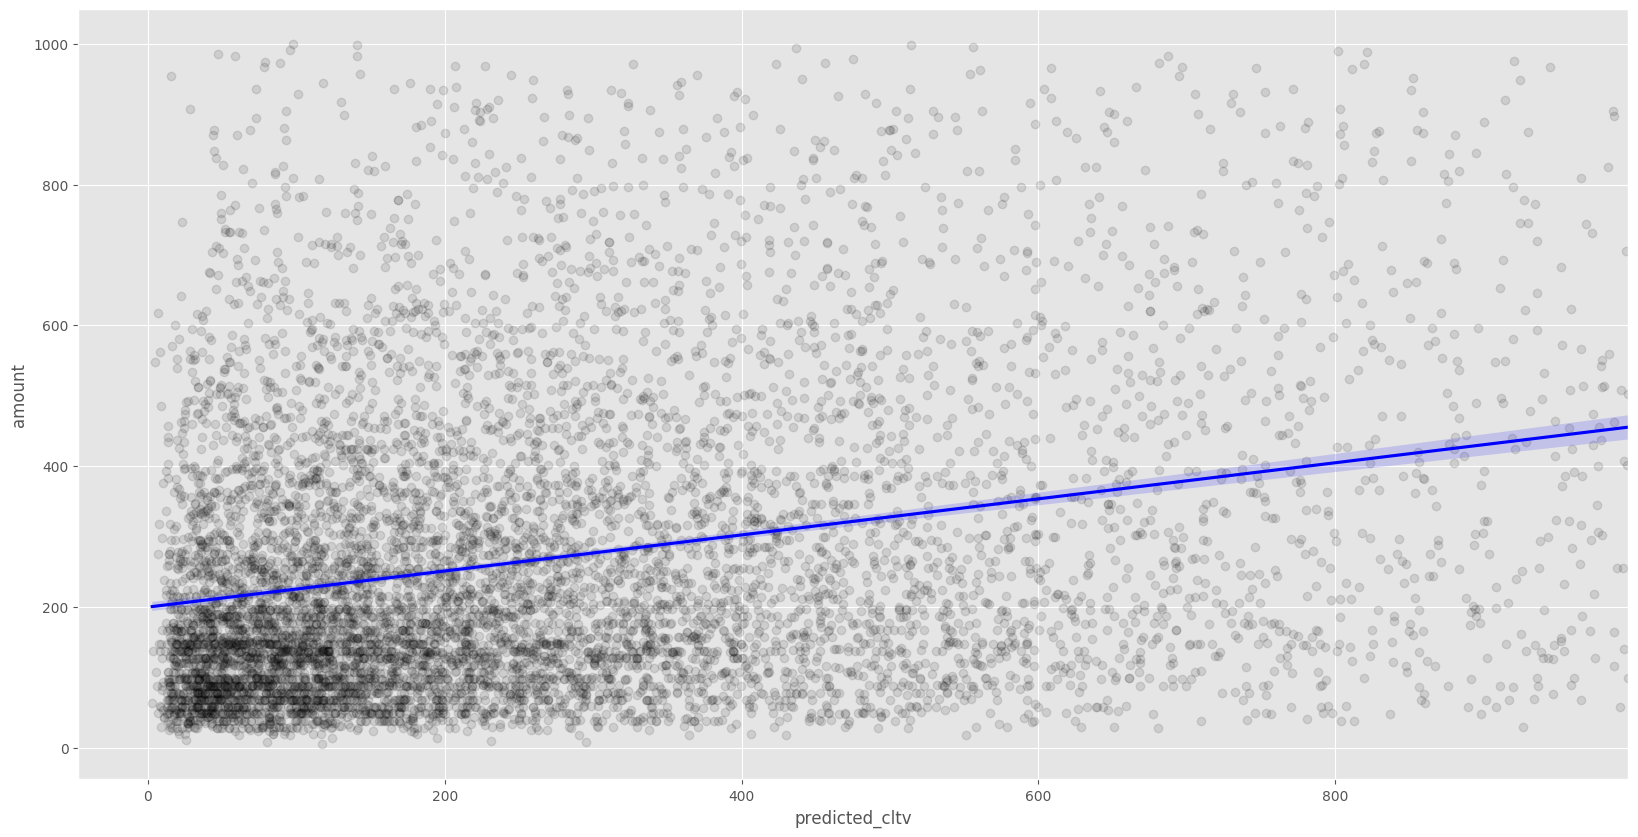

In [2985]:
sns.regplot(dff_r.predicted_cltv, dff_r.amount, scatter_kws={"color": "black", 'alpha':0.1}, line_kws={"color": "blue"})
dff_r[['predicted_cltv','amount']].corr()

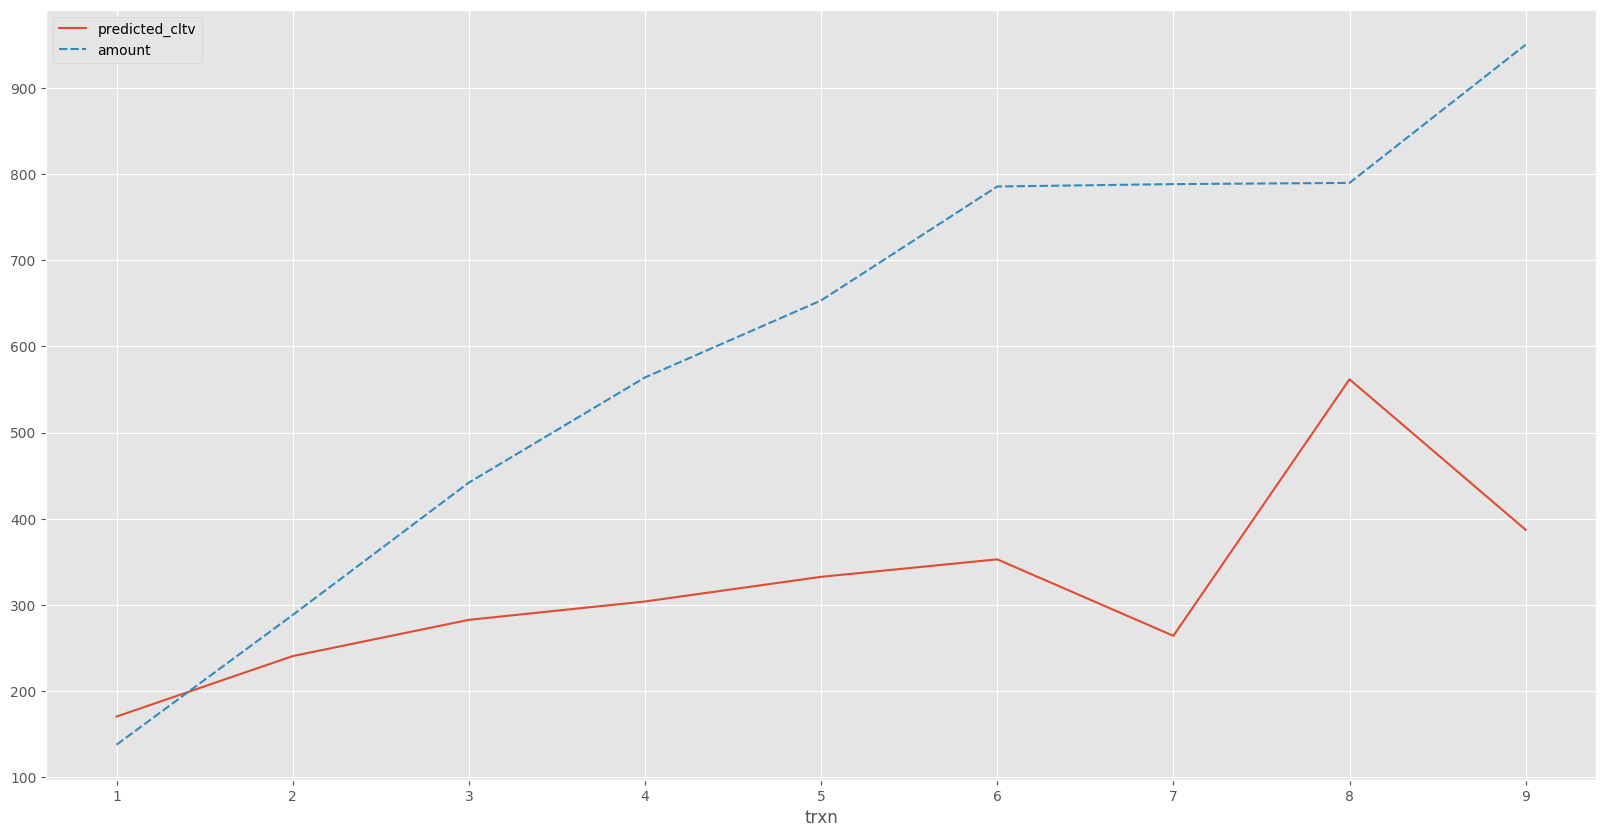

In [2986]:
z = dff_r.groupby('trxn')[['predicted_cltv', 'amount']].median()
sns.lineplot(data=z[z.index <10].iloc[:, :2])

In [2987]:
z = z.reset_index()
z

,trxn,predicted_cltv,amount
0,1,170.6910,138.00000
1,2,240.7940,288.50000
2,3,282.8375,442.00000
3,4,304.1480,564.00000
4,5,332.7400,653.33330
5,6,353.0170,785.50000
6,7,264.3145,788.27080
7,8,561.8720,789.66660
8,9,387.2880,949.95200
9,10,569.8005,663.57445


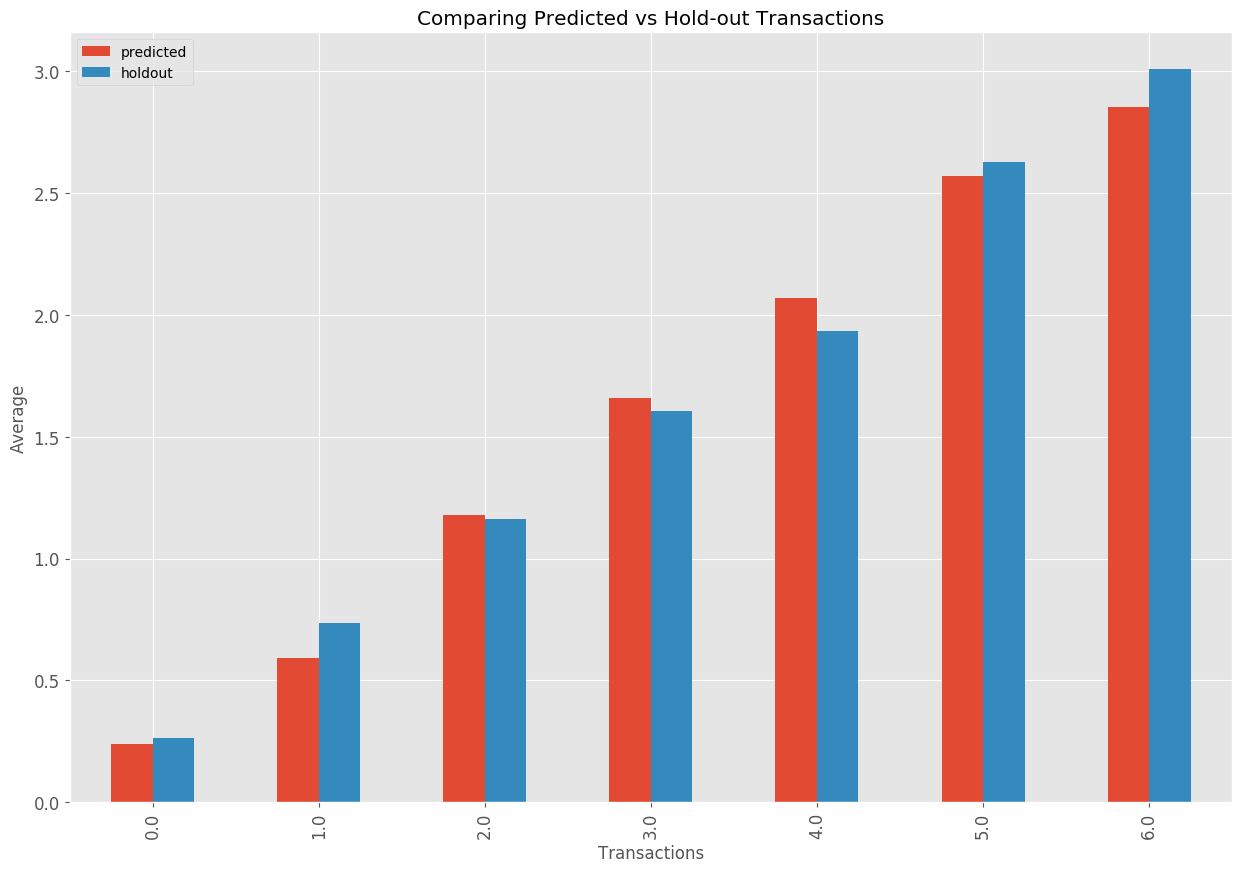

In [2258]:
#import matplotlib.pyplot as plt
ax = df_y[['predicted','holdout']].plot(kind='bar', title ="Comparing Predicted vs Hold-out Transactions", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Transactions", fontsize=12)
ax.set_ylabel("Average", fontsize=12)
plt.show()

# Intuitive Explaination

We now have the prediction for the number of purchases a customer will make in the next 90 days.

the fourth customer, in 519 days, they purchased 1 time, so in one day they purchase 1/519 times = .00192.  The model predicts they will make .057 purchases in the next 90 days.  The predicted value is different that simply .00192*90 = .1734 due to various model assumptions, drop out rates, etc.


# Forecasting

In [296]:
engine = create_engine(url)
con = engine.raw_connection()

In [259]:
def bayes_forecast(y, x, d, lb, fam, pl, discount):
    k=1
    Y=y
    Xf = []
    prior_length = pl
    forecast_start = 0                                 
    forecast_end = len(Y)-1
    #discount = 0.98


    mod, samples = analysis(Y, X=x, family=fam,
    forecast_start=forecast_start,      
    forecast_end=forecast_end,         
    k=k,
    holiday = holidays,
    ntrend=2,
    seasPeriods=[52,12],
    nsamps=2000, 
    seasHarmComponents=[[1,2,3,4,5,6,7],[1,2]],
    prior_length=prior_length, 
    rho=.6,
    deltrend=discount,                      
    delregn=discount,                        
    delVar=discount,
    delseas=discount,
    s0=0.01)

    forecast = median(samples)
    ci = 95
    alpha = (100-ci)/2
    upper = np.percentile(samples, [100-alpha],axis=0).reshape(-1)
    lower = np.percentile(samples, [alpha],axis=0).reshape(-1)
    #x_axis = np.arange(0,y[140:].shape[0],1)
    
    #if x_f is None:
    #    Xf == None
    #else:
    #    Xf = x_f.reshape(-1,1)
    #    
    #future_y = median(mod.forecast_path(tf, X=Xf, nsamps=1000))
    
    print(np.round(MAPE(Y[-lb:], forecast[-lb:]), 4))

    lb = lb

    plt.figure(figsize=(24,15)) 
    plt.plot(d[-lb:], y[-lb:], color='black', linewidth=1, label='Actual')
    plt.plot(d[-lb:],forecast[-lb:], linestyle='--', linewidth=1, label='Predicted', color='red')
    plt.fill_between(d[-lb:], upper[-lb:], lower[-lb:], alpha=.1, color='r', label='95% CI')
    plt.legend(loc="upper left")
    plt.suptitle('Actual vs. Predicted', fontsize=30)
    return plt, forecast, mod, y, d
    

In [255]:
def future(mod, forecast, new_x, t, y, d, lb):
    X = []
    if new_x is None:
        X == None
    else: 
        X = new_x.reshape(-1,1)
    
    future_y = mod.forecast_path(t, X=X, nsamps=1000)
    fy_median = median(future_y)
    
    # set the future date
    d = pd.to_datetime(d)
    future_dates = pd.date_range(d.max(), periods=t, freq='W')[-t:]
    
    ci = 95
    alpha = (100-ci)/2
    upper = np.percentile(future_y, [100-alpha],axis=0).reshape(-1)
    lower = np.percentile(future_y, [alpha],axis=0).reshape(-1)
    
    plt.figure(figsize=(24,15)) 
    plt.plot(d[-lb:], y[-lb:], color='black', linewidth=1, label='Actual')
    plt.plot(d[-lb:], forecast[-lb:], linestyle='--', linewidth=1, label='Predicted', color='red')
    plt.plot(future_dates, fy_median, color='blue')
    plt.fill_between(future_dates, upper, lower, alpha=.1, color='b', label='95% CI')
    
    return fy_median, future_dates

In [30]:
def make_forecast_df(date, actual, forecast, future, future_dates, lb):
    xdf_sales = pd.DataFrame(date[-lb:]).reset_index(drop=True)
    ydf_sales = pd.DataFrame(actual[-lb:]).reset_index(drop=True)
    fdf_sales = pd.DataFrame(forecast[-lb:]).reset_index(drop=True)
    f_sales_df = pd.concat([xdf_sales, ydf_sales, fdf_sales,], axis=1)
    f_sales_df.columns=['date', 'actual', 'predicted']
    x_fut = pd.DataFrame(future_dates).reset_index(drop=True)
    y_fut = pd.DataFrame(future).reset_index(drop=True)
    fut_df = pd.concat([x_fut, y_fut], axis=1)
    fut_df.columns=['date', 'forecast']
    sales_df = pd.concat([f_sales_df, fut_df], axis=0)
    return sales_df

### Get FORECAST Data

In [284]:
df_f = pd.read_sql(sql_forecast, con)

In [286]:
import datetime 
df_f.columns = map(str.lower, df_f.columns)
df_f = df_f[df_f.week_date > pd.Timestamp(2015,12,31)][:-1]
df_f

,week_date,total_gross_margin,avg_disc,a_price,pdisc,total_units,total_orders
53,2016-01-04,9.810230e+03,8.304932,46.706922,0.177809,292,113
54,2016-01-11,1.706005e+04,7.280961,48.816876,0.149148,481,196
55,2016-01-18,1.324910e+04,7.127248,50.272752,0.141772,341,152
56,2016-01-25,1.258807e+04,6.785155,51.125379,0.132716,313,135
57,2016-02-01,1.419038e+04,6.908478,56.033078,0.123293,336,149
...,...,...,...,...,...,...,...
306,2020-11-09,2.276827e+06,9.741605,80.655876,0.120780,55194,24018
307,2020-11-16,2.672563e+06,9.222273,80.480298,0.114590,61357,25847
308,2020-11-23,4.276532e+06,9.882493,75.543059,0.130819,100347,37412
309,2020-11-30,4.899281e+06,8.483831,80.187097,0.105800,98865,44164


# Test

In [346]:
x2 = np.array([x, x1])

In [357]:
orders_future

array([ 85241. ,  72026.5,  62780. ,  56833. ,  55105.5,  57671. ,
        60163.5,  64133. ,  69189. ,  70090. ,  69923.5,  73035.5,
        80422.5,  97091. , 117660.5, 139217.5, 159925.5, 166809. ,
       171881.5, 178036. , 184328. , 192234.5, 198307.5, 193722.5,
       196646. , 188347. ])

In [358]:
x2_f = np.array([orders_future, v0])

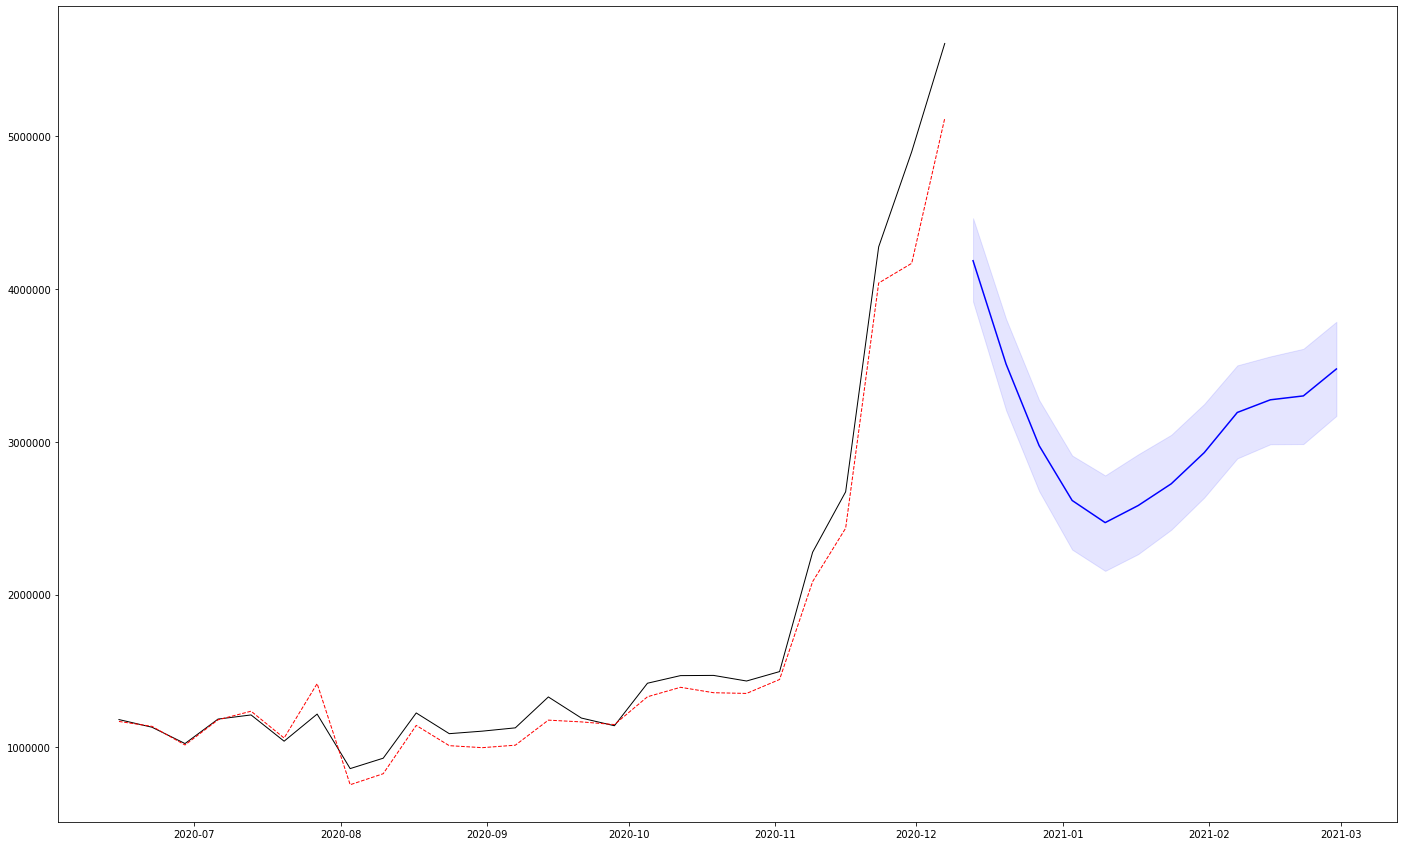

In [391]:
sales_fut, future_dates = future(mod_sales, f, x2_f.reshape(-1,1), 12, y, d, 26)

In [364]:
sales_fut

array([4635581.27721982, 4062446.57371479, 3539788.94054271,
       3142462.21222139, 2960599.68329507, 3016622.68626988,
       3122230.56315991, 3342565.51929736, 3610217.85656847,
       3730937.10163196, 3827446.50645081, 4003288.97513637])

6.3131


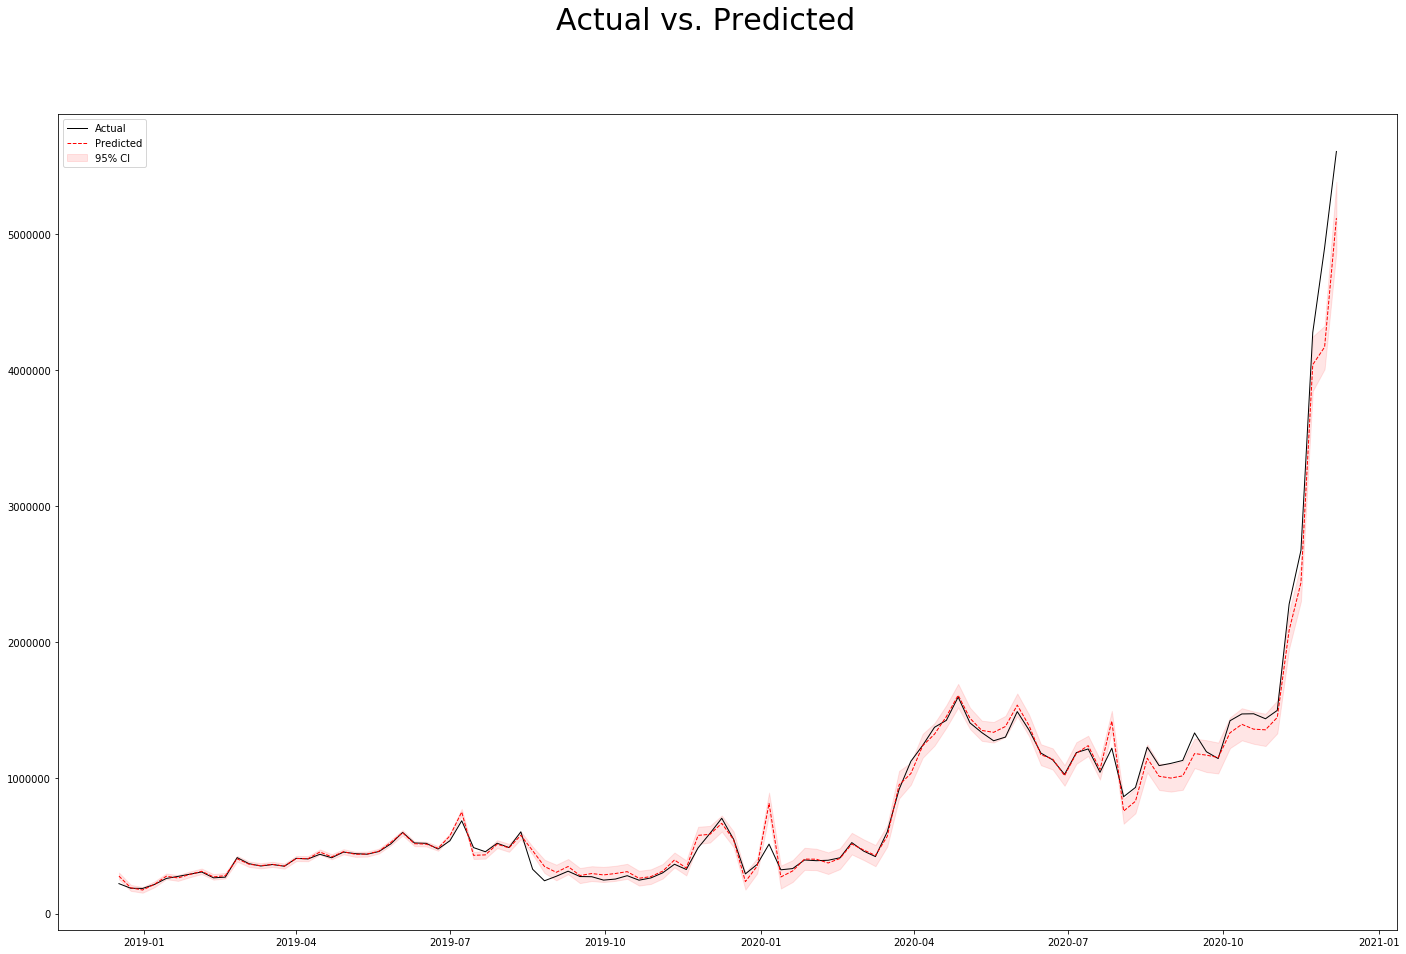

In [390]:
plot, f, mod_sales, y, d = bayes_forecast(y, x2.reshape(-1,1), d, 104, 'normal', 4, .98)

## Sales Forecast
here we are using "number of orders" as an independent variable to predict Sales

In [360]:
# For Forecasting Sales
y = df_f.total_gross_margin.values
x = df_f.total_units.values
x1 = df_f.pdisc.values
d = df_f.week_date
print(len(d))
v = np.repeat(x1[-1:],12)
v0 = np.repeat(.0,12)
v1 = np.repeat(.05,12)
v2 = np.repeat(.1,12)
v3 = np.repeat(.15,12)
v4 = np.repeat(.2,12)
v5 = np.repeat(.25,12)
v6 = np.repeat(.3,12)

258


17.8254
[86555.5 75227.5 66010.5 60894.5 57065.  59207.  59628.  66744.5 68249.5
 70001.  70167.  73472.5]


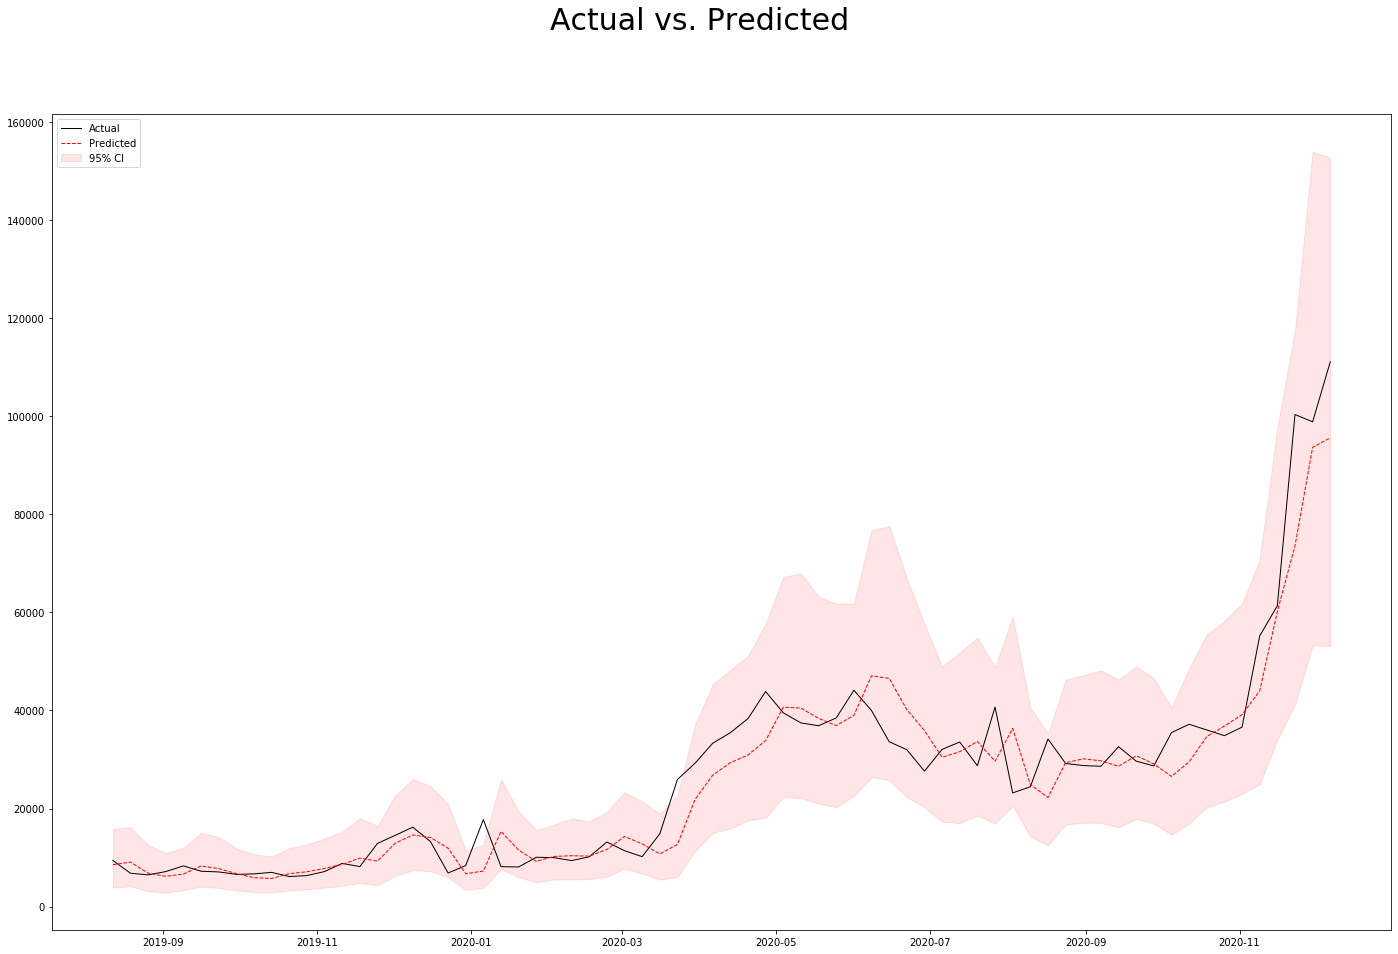

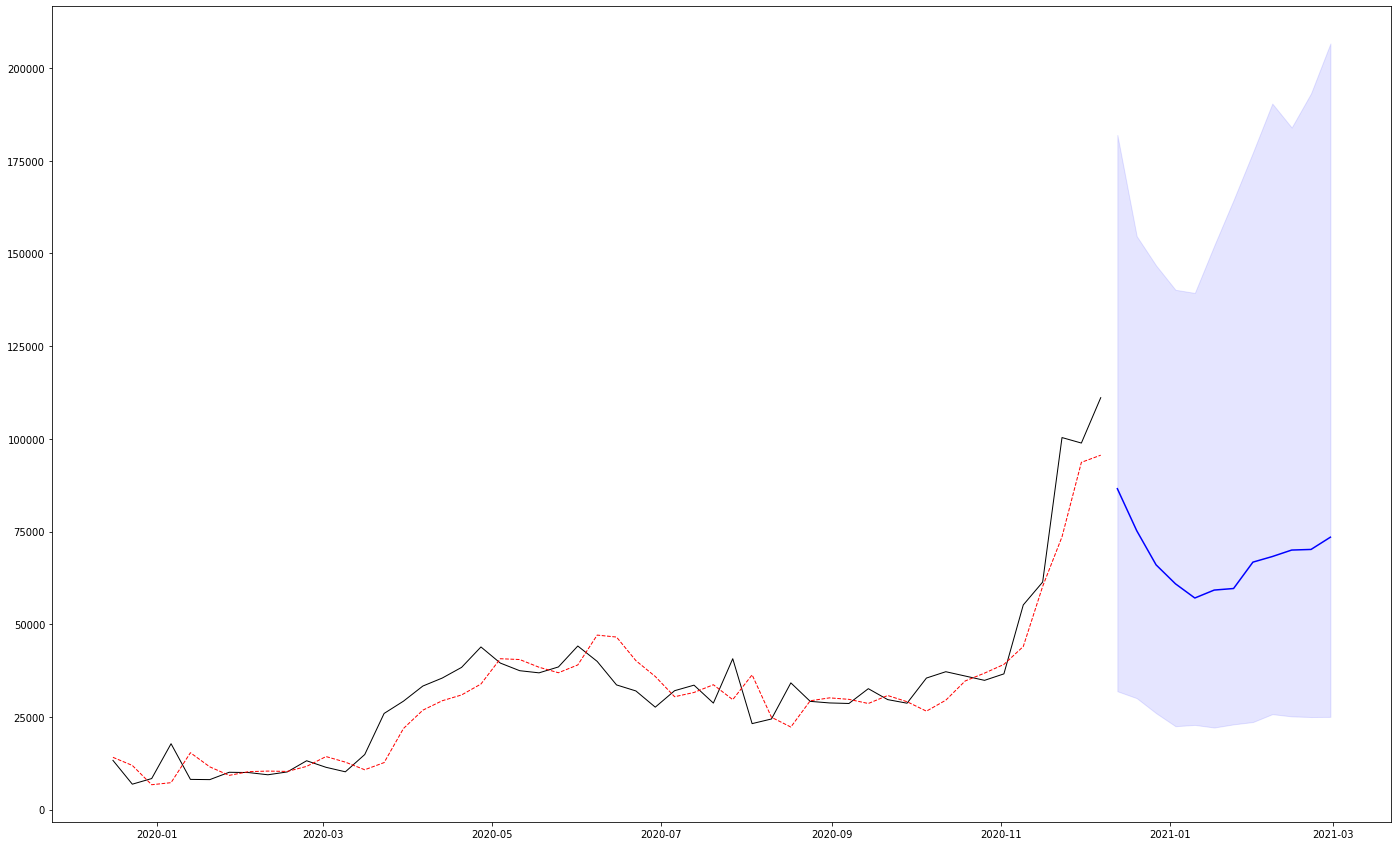

In [361]:
prior_length = 4
look_back = 70
discount = .96

# Need to predict Orders first, since it is the independent variable
plot_orders, orders_f, orders_mod, y_orders, d_orders = bayes_forecast(x, x1, d, look_back, 'poisson', prior_length, discount)

# run the model into the future N steps
orders_future, fo_date = future(orders_mod, orders_f, v0, 12, y_orders, d, 52)
print(orders_future)

16.94


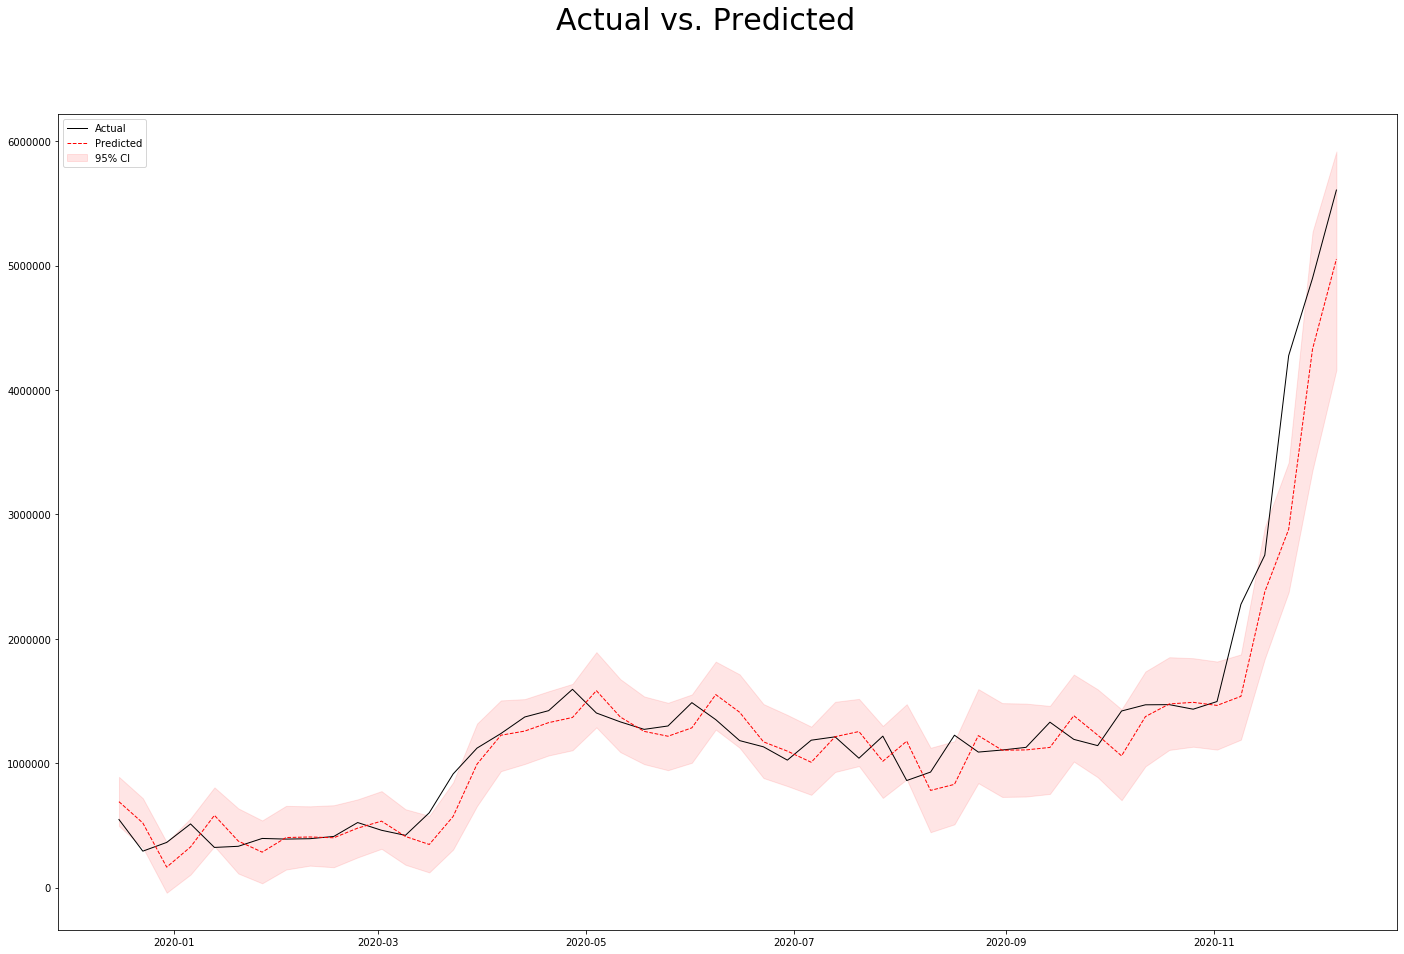

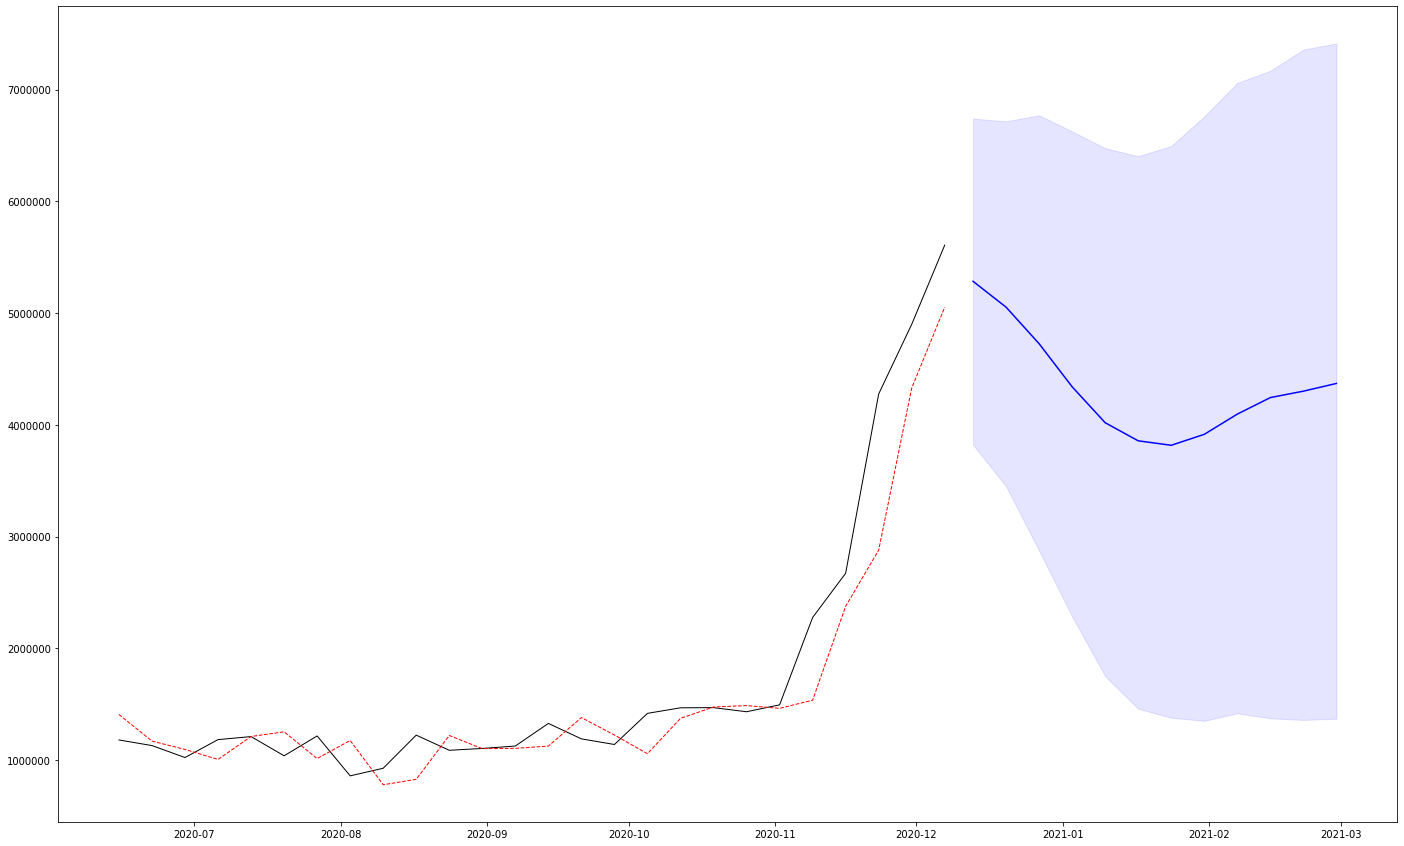

In [332]:
# using Discount to predict Sales
plot, f, mod_sales, y, d = bayes_forecast(y, x1, d, 52, 'normal', 4, .94)
sales_fut, future_dates = future(mod_sales, f, v0, 12, y, d, 26)
#plt.plot(sales_fut)

# Linear Regression

In [19]:
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics

In [20]:
lr_sql = """WITH first_order AS
(
    select
      cp.unique_customer_id
    , cp.first_order_id
    , cp.last_order_id
    , DATE_PART(MONTH, olr.order_date::date) as fo_date
    , first_order_fc_channel AS fo_channel
    , first_order_fc_vendor AS fo_vendor
    , sum(olr.gross_margin) AS fo_gross_margin
    , sum(olr.num_units) AS fo_num_units
    , sum(olr.discount_amount) as fo_discount_amt
    , sum(olr.shipping_amount) AS fo_shipping_amt
    , sum(olr.refund_amount) AS fo_refund_amt
    from drp.customer_profiles cp
    left join drp.order_line_revenue olr on olr.order_id = cp.first_order_id
    group by cp.unique_customer_id, cp.first_order_id, cp.last_order_id, order_date, fo_channel, fo_vendor
    --limit 100
)
SELECT
      cp.unique_customer_id
    , fo_channel
    , fo_vendor
    , fo_date
    , sum(fo_gross_margin) AS fo_gross_margin
    , sum(fo_num_units) AS fo_num_units
    , sum(fo_discount_amt) AS fo_discount_amt
    , sum(fo_shipping_amt) AS fo_shipping_amt
    , sum(fo_refund_amt) AS fo_refund_amt
    , CASE WHEN fo_refund_amt > 0 THEN 1 ELSE 0 END AS refund_flag
    , sum(cp.gross_margin) AS total_gross_margin --DV
    , sum(cp.num_orders) AS number_orders --DV
    , cp.last_order_date as lo_date
FROM drp.customer_profiles cp
LEFT JOIN first_order fo ON cp.unique_customer_id = fo.unique_customer_id
WHERE lo_date < '2020-12-01'
GROUP BY cp.unique_customer_id, lo_date, fo_channel, fo_vendor, fo_date, refund_flag
"""

In [21]:
lr_sql_new = """WITH first_order AS
(
    select
      cp.unique_customer_id
    , cp.first_order_id
    , cp.last_order_id
    , DATE_PART(MONTH, olr.order_date::date) as fo_date
    , first_order_fc_channel AS fo_channel
    , first_order_fc_vendor AS fo_vendor
    , sum(olr.gross_margin) AS fo_gross_margin
    , sum(olr.num_units) AS fo_num_units
    , sum(olr.discount_amount) as fo_discount_amt
    , sum(olr.shipping_amount) AS fo_shipping_amt
    , sum(olr.refund_amount) AS fo_refund_amt
    from drp.customer_profiles cp
    left join drp.order_line_revenue olr on olr.order_id = cp.first_order_id
    group by cp.unique_customer_id, cp.first_order_id, cp.last_order_id, order_date, fo_channel, fo_vendor
    --limit 100
)
SELECT
      cp.unique_customer_id
    , fo_channel
    , fo_vendor
    , fo_date
    , sum(fo_gross_margin) AS fo_gross_margin
    , sum(fo_num_units) AS fo_num_units
    , sum(fo_discount_amt) AS fo_discount_amt
    , sum(fo_shipping_amt) AS fo_shipping_amt
    , sum(fo_refund_amt) AS fo_refund_amt
    , CASE WHEN fo_refund_amt > 0 THEN 1 ELSE 0 END AS refund_flag
    , sum(cp.gross_margin) AS total_gross_margin --DV
    , sum(cp.num_orders) AS number_orders --DV
    , cp.last_order_date as lo_date
FROM drp.customer_profiles cp
LEFT JOIN first_order fo ON cp.unique_customer_id = fo.unique_customer_id
WHERE lo_date >= '2020-12-01'
GROUP BY cp.unique_customer_id, lo_date, fo_channel, fo_vendor, fo_date, refund_flag
"""

In [22]:
df_lr = pd.read_sql(lr_sql, connection)

In [23]:
df_lr_new = pd.read_sql(lr_sql_new, connection)

In [24]:
df_lr_red = df_lr.dropna()
len(df_lr_red)

540630

### Processing New Customers

Customers that have made 1 purchase in the past 30 days

In [491]:
df_lr_new = df_lr_new[df_lr_new.number_orders < 2].dropna()
len(df_lr_new)

50697

In [492]:
df_lr_new.describe()

,fo_date,fo_gross_margin,fo_num_units,fo_discount_amt,fo_shipping_amt,fo_refund_amt,refund_flag,total_gross_margin,number_orders
count,50697.000000,50697.000000,50697.000000,50697.000000,50697.000000,50697.000000,50697.000000,50697.000000,50697.000000
mean,11.997968,104.900462,2.081524,21.254413,1.773320,0.214501,0.002387,104.952053,0.996923
std,0.108680,81.310789,1.764702,34.370091,3.647377,5.457013,0.048796,81.319082,0.055387
min,2.000000,-238.010000,0.000000,0.000000,0.000000,0.000000,0.000000,-238.010000,0.000000
25%,12.000000,62.630000,1.000000,0.000000,0.000000,0.000000,0.000000,62.630000,1.000000
50%,12.000000,77.300000,2.000000,16.800000,0.000000,0.000000,0.000000,77.300000,1.000000
75%,12.000000,128.900000,2.000000,33.600000,0.000000,0.000000,0.000000,128.900000,1.000000
max,12.000000,3030.300000,66.000000,2408.800000,23.000400,468.720000,1.000000,3030.300000,1.000000


In [518]:
dummies_new = pd.get_dummies(df_lr_new, columns=['fo_channel','fo_vendor']).rename(columns=lambda x: 'Category_' + str(x))
df6 = pd.concat([df_lr_new, dummies_new], axis=1)
#df3 = df.drop(['fo_channel'], inplace=True, axis=1)
df7 = df6.drop(['fo_channel', 'fo_vendor', 'fo_date', 'lo_date', 'unique_customer_id', 
                'total_gross_margin', 'number_orders', 'Category_unique_customer_id',
       'Category_fo_gross_margin', 'Category_fo_num_units',
       'Category_fo_discount_amt', 'Category_fo_shipping_amt',
       'Category_fo_refund_amt', 'Category_refund_flag',
       'Category_total_gross_margin', 'Category_number_orders',
       'Category_lo_date'], axis=1, inplace=False).copy()
df7

,fo_gross_margin,fo_num_units,fo_discount_amt,fo_shipping_amt,fo_refund_amt,refund_flag,Category_fo_date,Category_fo_channel_(unavailable),Category_fo_channel_Direct,Category_fo_channel_Display,Category_fo_channel_Email,Category_fo_channel_Missing from GA,Category_fo_channel_Organic Search,Category_fo_channel_Other Advertising,Category_fo_channel_Paid Search,Category_fo_channel_Referral,Category_fo_channel_Social Network,Category_fo_vendor_Missing from GA
2,96.48,2,33.6,0.0,0.0,0,12,0,0,0,0,1,0,0,0,0,0,1
4,61.54,1,0.0,0.0,0.0,0,12,0,1,0,0,0,0,0,0,0,0,1
7,85.60,2,28.4,0.0,0.0,0,12,0,0,0,1,0,0,0,0,0,0,1
12,62.63,1,0.0,0.0,0.0,0,12,0,0,0,0,0,0,1,0,0,0,1
13,54.80,1,0.0,6.0,0.0,0,12,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79659,77.30,1,0.0,0.0,0.0,0,12,0,0,0,0,0,0,0,1,0,0,1
79661,57.70,1,19.6,0.0,0.0,0,12,0,0,0,0,0,1,0,0,0,0,1
79662,476.18,10,163.4,0.0,0.0,0,12,0,0,0,1,0,0,0,0,0,0,1
79663,70.92,1,0.0,0.0,0.0,0,12,0,0,0,0,0,0,0,1,0,0,1


In [520]:
X_vars_new = df7[col]

In [594]:
y_pred_hvc = rf_model.predict(X_vars_new)

# New OBS: Class Prediction of Repeat
y_pred_rpt = rf_model_rpt.predict(X_vars_new)
# New OBS: Repeat - Probabilities for each class
y_prob_rpt = rf_model_rpt.predict_proba(X_vars_new)[:, 1]

In [640]:
send_data(df10, 'new_customer_classification')

new_customer_classification updated!


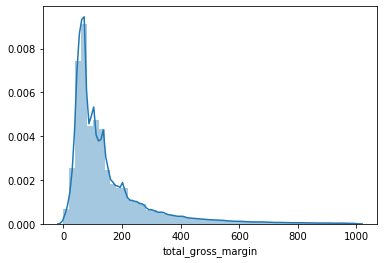

In [423]:
sns.distplot(df_lr_red[(df_lr_red.total_gross_margin < 1000) & (df_lr_red.total_gross_margin >= 0)].total_gross_margin)

In [611]:

logreg = LogisticRegression(class_weight="balanced", C=.01)
#logreg = LogisticRegression(C=.0001)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

Accuracy of logistic regression classifier on test set: 0.79
[[118050  30092]
 [  2616   4852]]


In [612]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88    148142
           1       0.14      0.65      0.23      7468

   micro avg       0.79      0.79      0.79    155610
   macro avg       0.56      0.72      0.55    155610
weighted avg       0.94      0.79      0.85    155610



## Random Forest

In [613]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_model_rpt = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               #max_depth =8,
                               max_features = 'sqrt',
                              class_weight='balanced')
# Fit on training data
rf_model_rpt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [614]:
# Actual class predictions
rf_predictions = rf_model_rpt.predict(X_test)
# Probabilities for each class
rf_probs = rf_model_rpt.predict_proba(X_test)[:, 1]

In [615]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93    148142
           1       0.13      0.32      0.19      7468

   micro avg       0.87      0.87      0.87    155610
   macro avg       0.55      0.61      0.56    155610
weighted avg       0.92      0.87      0.89    155610



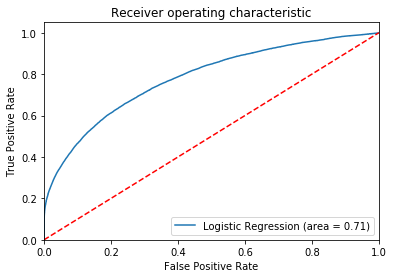

In [512]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## StatsModels

In [279]:

X = df_LR2[['fo_gross_margin', 'fo_num_units', 'fo_discount_amt', 'fo_shipping_amt', 'fo_refund_amt']]
Y = df_LR2.total_gross_margin
X = sm.add_constant(X)
lr_result = OLS(Y,X).fit().summary()

In [280]:
lr_result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     total_gross_margin   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                 3.690e+04
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:37:55   Log-Likelihood:            -3.3896e+06
No. Observations:              518393   AIC:                         6.779e+06
Df Residuals:                  518387   BIC:                         6.779e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.6020      0.428     64.566      0.000      26.764      28.440
fo_gross_margin     1.6020      0.007    219.753      0.000       1.588       1.616
fo_num_units      -10.3700      0.414    -25.058      0.000     -11.181      -9.559
fo_discount_amt    -0.2310      0.012    -19.958      0.000      -0.254      -0.208
fo_shipping_amt     0.5662      0.046     12.286      0.000       0.476       0.657
fo_refund_amt       0.5578      0.010     57.242      0.000       0.539       0.577
==============================================================================
Omnibus:                   540923.042   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42327040.155
Skew:                           5.237   Prob(JB):                         0.00
Kurtosis:                      46.010   Cond. No.                         235.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [281]:
X = df_LR2[['fo_gross_margin', 'fo_num_units', 'fo_discount_amt', 'fo_shipping_amt', 'fo_refund_amt']]
Y = df_LR2.hvc
X = sm.add_constant(X)
logit_mod = sm.Logit(Y,X)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.162734
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    hvc   No. Observations:               518393
Model:                          Logit   Df Residuals:                   518387
Method:                           MLE   Df Model:                            5
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                  0.1541
Time:                        11:38:43   Log-Likelihood:                -84360.
converged:                       True   LL-Null:                       -99733.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.4009      0.013   -342.094      0.000      -4.426      -4.376
fo_gross_margin     0.0146      0.000     83.083      0.000       0.014       0.015
fo_num_units       -0.1753      0.010    -17.333      0.000      -0.195      -0.155
fo_discount_amt    -0.0019      0.000     -7.031      0.000      -0.002      -0.001
fo_shipping_amt     0.0060      0.001      5.466      0.000       0.004       0.008
fo_refund_amt       0.0053      0.000     20.441      0.000       0.005       0.006
===================================================================================
"""

In [282]:
logit_res.pred_table()

array([[492124.,   1420.],
       [ 22212.,   2637.]])

In [283]:
yhat = logit_res.predict(X) 
prediction = list(map(round, yhat)) 

In [285]:
# confusion matrix 
cm = confusion_matrix(df_LR2.hvc, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(df_LR2.hvc, prediction))

Confusion Matrix : 
 [[492124   1420]
 [ 22212   2637]]
Test accuracy =  0.954412964681236
